Practice of neural network algorithm by creating a model from scratch only with NumPy. This is to learn how forward/backpropagation and weight normalization/activation of the simple single-layer neural network work. You will use the famous MNIST dataset, and you will need to compare the result under different normalization/activation settings of the same architecture using Pandas pipelines.

**All problems can be solved without explicit loops.**


## 1. Data preprocessing

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

RANDOM_STATE = 12345

The MNIST dataset was constructed from two datasets of the US National Institute
of Standards and Technology (NIST). The training dataset consists of handwritten
digits from 250 different people, 50 percent high school students and 50 percent
employees from the Census Bureau. Note that the test dataset contains handwritten digits from different people following the same split.

![alt text](https://dezyre.gumlet.net/images/Exploring+MNIST+Dataset+using+PyTorch+to+Train+an+MLP/MNIST+Dataset.png?w=900&dpr=1.0)

This MNIST dataset can be directly downloaded via various routes including tensorflow dataset repository, keras dataset, and scikit-learn. This time, you can use `sklearn.datasets` module.

In [6]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

It has 70,000 different handwriting instances. It usually has 60,000 instances in the training set and the remaining ones in the test set, but scikit-learn loads it as a whole. You may need to divide it into two.

In [7]:
X.shape, y.shape

((70000, 784), (70000,))

You can also check the class distribution. Is it balanced or not?

<BarContainer object of 10 artists>

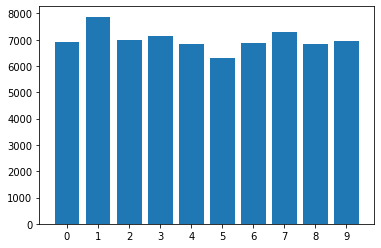

In [8]:
plt.bar(np.unique(y, return_counts = True)[0], np.unique(y, return_counts = True)[1])

You may also need to apply normalization for better performance. Since it is clear that its maximum value is 255, you can simply normalize it by dividing the whole value by 255 (then the dataset will range from 0 to 1). You can use NumPy's broadcasting to divide the matrix by one scalar value. It is also possible to further standardize it to have a centeralized mean, but this time it is optional. 
- Apply normalization to X to have the range [0, 1]

In [9]:
X_normalized = X/X.max() # CHANGE IT

If you take a look at `y`, it has string labels! It might be disturbing when you need to handle them later, so let's also convert them to an integer form.
- Change the type of the labels to integer

In [10]:
y_integer = y.astype(int) # CHANGE IT

Next, you need to split the dataset into two parts using scikit-learn's `train_test_split` method.
- Use scikit-learn's `train_test_split` to create training and test sets.
- Set **test_size** to 20%.
- Enable stratification and shuffling.
- use `X_normalized` and `y_integer`.
- set `random_state` to the pre-defined variable `RANDOM_STATE`.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_integer, test_size=0.20, random_state=RANDOM_STATE, stratify=y_integer) # CHANGE IT

Please print the mean and the standard deviation of `X_train` here (for validation purpose).

In [12]:
X_train.mean(), X_train.std()

(0.13086888228505666, 0.30836916270386544)

Here you can check some of the instances that you get.

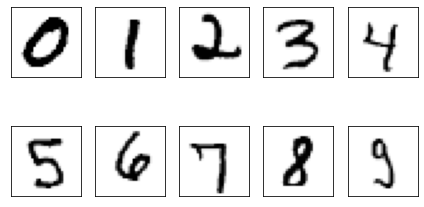

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
  img = X_train[y_train == i][0].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 2. Helper functions

First, you need to fix the labels, which are now in a sparse form, to have a one-hot encoded form for better computation of error terms using NumPy's vectorization. Let's create a function that receives a label vector and transform it into a one-hot encoded label matrix.

- Complete the `one_hot` function.

In [14]:
def one_hot(y):
  """
  Input:
    - y : set of labels

  Output:
    - onehot: a one-hot-encoded array

  This function creates an one-hot encoded representation of the labels.
  This means that you will have a set of binary columns indicading each possible class.

  You have to develop this one hot encoding strategy without using Python for loop

  Expected outcome:
    one_hot(np.array([1,0,2,3]))

    array([[0., 1., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]])
  """
  onehot = np.equal.outer(y,np.unique(y)).astype(int)
  return onehot # CHANGE IT


Test your code here (see the expected outcome above).

In [15]:
one_hot(np.array([1,0,2,3]))

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

Next, you may also need a sigmoid function for the output values as you are dealing with a classification problem. Sigmoid can be represented as follows:

$$ h_ \theta (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-x} }  $$ 


- Complete the sigmoid function below that supports both vectors and scalars (this can be automatically handled if you use NumPy).

In [16]:
def sigmoid(x):
  """
  Input:
    - z: input vector or scalar value

  Output:
    - sigmoid: output sigmoid-transformed vector or scalar value

  Calculate the sigmoid value of the input.
  
  Expected outcome:
    sigmoid(np.array([np.inf, -np.inf, 0]))

    array([1. , 0. , 0.5])
  """
  x = 1/(1 + np.exp(-x))
  return x # CHANGE IT

Test your code here (see the expected outcome above).

In [17]:
sigmoid(np.array([np.inf, -np.inf, 0]))

array([1. , 0. , 0.5])

## 3. Our FCN classifier with the class structure

Now it is time to create your neural network model from scratch! You eventually need to integrate everything into scikit-learn's pipeline, so it's important to have an appropriate class structure. To do this, you may need to extend `BaseEstimator` and `TransformerMixin` to make scikit-learn recognize that your class is a valid classifier.

You are going to develop a neural network with one layer for simplicity. That means you will have two different sets of weights.

- First layer: [input size (number of features), hidden layer size]
- Second layer (or output layer): [hidden layer size, output size (number of classes)]

In the class structure `FullyConnectedNetwork` below, you will develop five different methods as follows:
 - `compile`: Given parameters, this function will initialize weight and bias values needed for our neural network model.
   - Here, you will initialize bias and weights based on a chosen initialization technique.
        - You need to implement three different options: normal, Xavier, and he
        - Each technique initializes the weight using the normal distribution but different standard deviation. The mean value remains the same.
          - Normal: 
$ \mu = 0, \sigma = 0.1 $
          - Xavier: 
$ \mu = 0, \sigma = \sqrt{\frac{2}{n_{in} + n_{out}}}$
          - He:
$ \mu = 0, \sigma = \sqrt{\frac{2}{n_{in}}}$
 - `forward`: Perform a forward propagation with the weights saved in the model.
 - `back_propagation`: Perform a back propagation (training the model).
    - Most of the derivative terms are already provided. You will only need to finish some part of it.
      - Weight and bias update
      - Derivative of the sigmoid function
        - $σ(x)=σ(x)(1−σ(x))$.

 - `fit`: Run the whole fitting process (forward and backpropagation for each batch).
 - `cost`: Calculate the cost (cross-entropy) together with the elastic net (l1/l2)
   - cross-entropy loss can be calculated as follows:
 - `predict`: With a trained model, perform a prediction of unseen data by running the forward propagation with the trained weight and bias.
 - `evaluate`: With trained weight and bias, perform a prediction of test data and calculate the performance metric (in our case, those are training and validation accuracy scores).

**This exercise is based on *Chapter 12* of the coursebook Python Machine Learning with some modification and additional tasks - so please note that the structure and requirements are not the same.**

You are free to check out the coursebook for reference. However, to solve the tasks, you should understand the logic clearly.

In [52]:
class FullyConnectedNetwork(BaseEstimator, TransformerMixin):
    def __init__(self, n_hidden=30, l2=0., l1=0., epochs=100, eta=0.001, validation_rate = 0.3,
                 shuffle=True, batch_size=1, init_technique = "normal", seed=None, debug=True):

        """
        The class structure receive the following parameters to construct and test the model:

        Input:
          - n_hidden: Number of hidden nodes.
          - l2: Lambda value for L2-regularization.
          - l1: Lambda value for L1-regularization.
          - epochs: Number of passes over the training set.
          - eta: Learning rate.
          - validation_rate: size of the validation set.
          - shuffle: Enabling shuffling option of the dataset every epoch.
          - batch_size: Number of training examples per batch.
          - init_technique: Indicator for an initialization technique.
          - seed: Random seed for initializing weights and shuffling.
        """
        self.seed = seed

        # DEFINE YOUR RANDOM NUMBER GENERATOR USING THE INPUT SEED
        # WARNING! It is strictly required to use "np.random.default_rng" to generate random numbers.
        self.random = np.random.default_rng(self.seed) # CHANGE IT
        
        self.n_hidden = n_hidden
        self.l2 = l2
        self.l1 = l1
        self.epochs = epochs
        self.eta = eta
        self.validation_rate = validation_rate
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.debug = debug
        self.init_technique = init_technique

    def compile(self, n_features, n_outputs):
        """
        Initializing the weights of the model

        - Here you will initialize bias and weights based on chosen initialization technique.
        - The classifier has three different options: normal, xavier, and he
        - Each technique initializes the weight using the normal distribution but different standard deviation.
        - Use self.init_technique to check the chosen technique and use self.random to perform the sampling.

        Input:
          - n_features: input size of the network
          - n_outputs: output size of the network
          - Unit size of the layer is given as self.n_hidden

        Steps:
          ---1. Check if you have created self.random using NumPy's random number generator.
             You will use this generator throughout this function.
        
          self.random = np.random.default_rng(self.seed)


          2. Create lists self.W and self.B which will keep the weight values for each layer.
          3. Set mean and standard deviation for different initialization technique.
          4. Create weights and bias for the linkage between inputs and the first layer.
            - Weight should have the size [n_features, self.n_hidden].
            - Bias should have the size [self.n_hidden].
            - Weight initialization should be applied to the weights only.
            - Bias should be initizalied by zeros.
          5. Create weights and bias for the linkage between the first layer and the output layer.
            - Weight should have the size [self.n_hidden, n_outputs].
            - Bias should have the size [n_outputs].
            - Weight initialization should be applied to the weights only.
            - Bias should be initizalied by zeros.
          5. Save the weights to self.W and biases to self.B. Each list should have two elements for each layer.

          WARNING! It is strictly required to use "np.random.default_rng" to generate random numbers.
        """

        self.B = [] # CHANGE IT
        self.W = [] # CHANGE IT

        # 1. Creating weights and bias for [input -> hidden]
        # Use specific initialization techniques for weights
        # Weights should have the size (n_features, self.n_hidden)
        # Use np.zeros for bias with the size 'self.n_hidden'
        if self.init_technique == 'normal':
          sigma = 0.1
        if self.init_technique == 'xavier':
          sigma = np.sqrt(2/(n_features + n_outputs))
        if self.init_technique == 'he':
          sigma = np.sqrt(2/(n_features))
        b_h = np.zeros(self.n_hidden) # CHANGE IT
        w_h = np.random.normal(0, sigma, (n_features, self.n_hidden)) # CHANGE IT

        # 2. Append bias to self.B and weights to self.W
        self.B.append(b_h)
        self.W.append(w_h)
        # 3. Creating weights and bias for [hidden -> output]
        # Use specific initialization techniques for weights
        # Weights should have the size (self.n_hidden, n_outputs)
        # Use np.zeros for bias with the size 'n_outputs'

        b_out = np.zeros(n_outputs) # CHANGE IT
        w_out = np.random.normal(0, sigma, (self.n_hidden, n_outputs)) # CHANGE IT
        #w_out = np.random.Generator(0, sigma, (self.n_hidden, n_outputs))

        # 4. Append bias to self.B and weights to self.W
        self.B.append(b_out)
        self.W.append(w_out)

    def forward(self, X):
        """
        Given the dataset X, compute forward propagation step with the weights and bias saved in the list.
        This process eventually outputs ten numbers in our case as the dataset has ten outputs.
        (Please refer to the lecture slides for detailed computation process)
        Forward propagation is performed by multiple chained dot products of inputs and weights.
        
        Input:
          - X: features
        
        Output:
          - Z: Result of dot product of the weights and the previous output for each phase
          - A: A list that contains sigmoided values of A
        Steps:
          1. Create two lists Z and A.
          2. Take a dot product of X and the first weight self.W[0] - save the result into Z
          3. Apply sigmoid function to the first Z - save the result into A
          4. Take a dot product of A and the second weight self.W[1] - save the result into Z
          ---5. Apply sigmoid function to the second Z - save the result into A
          6. Return Z and A

        WARNING! Be careful when you multiply two matrices - think about which rows you are multiplying.
                 Wrong order in .dot() function can lead completely wrong result.
        """

        Z = [] # CHANGE IT
        A = [] # CHANGE IT

        # Step 1: net input of hidden layer
        # - You are calculating the first XW+b.
        # - Take a dot product of the input features and the initial weights.
        # - Add the outcome to list Z.
        z_h = np.dot(X, self.W[0]) + self.B[0]
        Z.append(z_h) # CHANGE IT

        # Step 2: activation of hidden layer
        # - Apply the sigmoid function to the dot producted outcome.
        # - Add the outcome to list A.
        a_h = sigmoid(z_h)
        A.append(a_h) # CHANGE IT

        # Step 3: net input of output layer
        # - You are calculating the second XW+b.
        # - Take a dot product of the intermediate features and the weights of the output layer.
        # - Add the outcome to list Z.
        z_output = np.dot(A, self.W[1]) + self.B[1]
        #z_output = np.dot(a_h, self.W[1]) + self.B[1]
        Z.append(z_output) # CHANGE IT

        # Step 4: activation output layer
        # - Apply the sigmoid function to the dot producted outcome.
        # - For simplicity, here the network uses sigmoid instead of softmax.
        # - Add the outcome to list A.
        a_output = sigmoid(z_output)
        A.append(sigmoid(a_output))
        A.append(a_output) # CHANGE IT

        return Z, A

    def predict(self, X):
        """
        
        Predict class labels by performing forward propagation.

        Input: 
          - X: Feature matrix.
        Output:
          - y_pred: Predicted class labels for all data instances.

        Steps:
          1. Run forward proparation on X and get Z, a.
          2. Calculate y_pred by using the final output (A[-1]) and with np.argmax
            - You have to choose the index of the one with the highest value, which means the highest probability.
          3. Return the prediction. You SHOULD perform the operation using NumPy's vectorization feature.
             This means that if you put many instances at once as an input, this function should calculate the result also at once.

        """
        Z, A = self.forward(X)
        y_pred = np.argmax(A[-1], axis=1) # CHANGE IT

        return y_pred

    def cost(self, y_truth, y_pred):
        """
        
        This function computes the cost for the classification task.
        The network supports Elastic net (combination of l1 and l2 with corresponding weights).

        Input:
          - y_truth: "One-hot encoded" class labels.
          - y_pred: Activation of the output layer (= output of the forward propagation function).
          - The weights for l1 and l2 are saved into self.l1 and self.l2.
        
        Output:
          - cost: Regularized cost

        Steps:
          1. Calculate the cross entropy between the truth (y) and predicted values (y*).
             - y * log(y*) - (1 - y) * log(1 - y*)
          2. Add l1 and l2 terms to the cost.
            - L1 term is the sum of absolute weight values.
            - L2 term is the sum of squared weight values.
            - You should multiply l1 and l2 ratio saved in self.l1 and self.l2 (this will decide the degree of regularization).
            - You should NOT include weights that belong to the bias values.
          3. Return the total cost (cross entropy + L1 term + L2 term).

        """
        L1 = self.l1 * ((np.sum(np.abs(self.W[0]))) + (np.sum(np.abs(self.W[1]))))
        L2 = self.l2 * (np.sum(self.W[0] ** 2) + np.sum(self.W[1] ** 2))
        cost =  np.sum((-y_truth * np.log(y_pred)) - ((1. - y_truth) * np.log(1. - y_pred))) + L1 + L2 # CHANGE IT
        
        return cost

    

    def back_propagation(self, X_train, batch_idx, A, y_truth):
      """
      Perform back propagation based on the result of forward propagation and true labels (for each batch).

      Input:
        X_train: Training features.
        batch_idx: The current batch indices from the fit function.
        A: Sigmoided output values - the result of forward propagation.
        y_truth: One-hot encoded true labels.

      Output:
        None
        You should update the weights and biases in self.W/self.B

      **** You only need to fill in some required parts marked as "CHANGE THIS PART" ****
      **** To get more information about the backpropagation process: 
           https://towardsdatascience.com/deriving-backpropagation-with-cross-entropy-loss-d24811edeaf9 ****
      """

      # OUTPUT WEIGHTS (LAYER-OUTPUT)
    def back_propagation(self, X_train, batch_idx, A, y_truth):
      # δC/δA * δA/δZ
      delta_out = A[-1] - y_truth[batch_idx]
      # δC/δA * δA/δZ * δZ/δW
      grad_w_out = np.dot(A[0].T, delta_out)
      # δC/δA * δA/δZ * δZ/δB
      grad_b_out = np.sum(delta_out, axis=0)

      #############################################
      # CHANGE THIS PART
    
      # Using the final gradients of the weight and bias (grad_w_out, grad_b_out), the network needs to update its current weight values.
      # The gradient of w and b are already calculated and all you need to do is to merge it with l1/l2 terms.
      # Change the values of self.W[1], self.B[1] (output weight and bias).
      # - You should also apply l1 and l2 normalization to the weight (not to the bias).
      # - You should use the learning rate (self.eta) when changing the value.


    # def back_propagation(self, X_train, batch_idx, A, y_truth):
    #   # δC/δA * δA/δZ
    #   delta_out = A[-1] - y_truth[batch_idx]
    #   # δC/δA * δA/δZ * δZ/δW
    #   grad_w_out = np.dot(A[0].T, delta_out)
    #   # δC/δA * δA/δZ * δZ/δB
    #   grad_b_out = np.sum(delta_out, axis=0) #-----
      delta_w_out = grad_w_out + self.l1*self.W[1] + self.l2*self.W[1] # CHANGE IT
      delta_b_out = grad_w_out # CHANGE IT
      self.W[1] = self.W[1] - self.eta * delta_w_out # CHANGE IT
      self.B[1] = self.B[1] - self.eta * delta_b_out # CHANGE IT

      # END OF CHANGE
      #############################################
      
      # HIDDEN WEIGHTS (INPUT-LAYER)

      #############################################
      # CHANGE THIS PART

      # To continue to take derivatives backwards, you need to take a derivative of the sigmoid function.
      # Here you are trying to take derivative of a sigmoided output A[0].
      # Derivative of sigmoid σ(x) can be represented as σ(x)(1−σ(x)).
      
      sigmoid_derivative_h = A[0] * (1 - A[0]) # CHANGE IT

      # END OF CHANGE
      #############################################

      delta_h = (np.dot(delta_out, self.W[1].T) * sigmoid_derivative_h)
      #delta_h = (np.dot(delta_w_out, self.W[1].T) * sigmoid_derivative_h)
      #delta_h = (np.dot(delta_w_out, self.W[1]) * sigmoid_derivative_h)
      grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
      #grad_w_h = np.dot(X_train[batch_idx], delta_h)
      grad_b_h = np.sum(delta_h, axis=0)
      
      
      
      # delta_w_h = grad_w_h + self.l1*self.W[0] + self.l2*self.W[0] # CHANGE IT
      # delta_b_h = grad_b_h # CHANGE IT
      
      # self.W[0] = self.W[0] - self.eta * delta_w_h # CHANGE IT
      # self.B[0] = self.B[0] - self.eta * delta_b_h # CHANGE IT

      #############################################
      # CHANGE THIS PART

      # Using the final gradients of the weight and bias (grad_w_h, grad_b_h).
      # The gradient of w and b are already calculated and all you need to do is to merge it with l1/l2 terms.
      # Change the values of self.W[0], self.B[0] (output weight and bias).
      # - You should also apply l1 and l2 normalization to the weight (not to the bias).
      # - You should use the learning rate (self.eta) when changing the value.

      delta_w_h = grad_w_h + self.l1*self.W[0] + self.l2*self.W[0] # CHANGE IT
      delta_b_h = grad_b_h # CHANGE IT
      
      self.W[0] = self.W[0] - self.eta * delta_w_h # CHANGE IT
      self.B[0] = self.B[0] - self.eta * delta_b_h # CHANGE IT



      #print(self.W[0])
      #print(self.W[0])
      # END OF CHANG
      #############################################

    
    def evaluate(self, epoch, X_train, X_valid, y_train, y_valid):
      """
      Evaluate performances on the training and validation sets per epoch
      
      Input:
        - epoch: Current epoch number.
        - X_train: Training features
        - X_valid: Validation features
        - y_train: Training labels
        - y_valid: Validation labels

      Output:
        - None
        Append the cost and performance metrics of current epoch to self.history
      """

      # Step 1. Call self.forward on X_train to calculate the output with current weights and bias of the model.
      Z, A = self.forward(X_train) # CHANGE IT

      # Step 2. call predict functions with both X_train and X_valid and save the predicted values accordingly.
      y_train_pred = self.predict(X_train) # CHANGE IT
      y_valid_pred = self.predict(X_valid) # CHANGE IT

      # Step 2. Call self.cost with y_train and y_train_pred.
      # Save it into the variable 'cost'.
      cost = self.cost(y_truth = one_hot(y_train), y_pred = A[1]) # CHANGE IT

      # Step 4. Calculate accuracy scores.
      # - between y_train_pred and y_train.
      # - between y_valid_pred and y_valid.
      train_acc = (y_train == y_train_pred).sum()/X_train.shape[0] # CHANGE IT
      valid_acc = (y_valid == y_valid_pred).sum()/X_valid.shape[0] # CHANGE IT

      # Step 5. Save the results into the dictionary.
      # This part is already complete.
      if self.debug == True:
        print('%d/%d | Cost: %.2f '
                        '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                        (epoch+1, self.epochs, cost,
                          train_acc*100, valid_acc*100))

      self.history['cost'].append(cost)
      self.history['train_acc'].append(train_acc)
      self.history['valid_acc'].append(valid_acc)

    
    def fit(self, X, y):
        """ 
        
        Learn weights from training data.

        Input
          - X: features (training+validation)
          - y: labels

        Output
          - self.history: information about cost and accuracy scores

        """
      #def fit(self, X, y):
        self.history = {'cost': [], 'train_acc': [], 'valid_acc': []}

        # Step 1: Select different training and test sets. Use scikit-learn's train_test_split.
        # Turn on the stratification option and use self.validation_rate
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=self.validation_rate) # CHANGE IT

        # Step 2: Compile (initialize) the parameters by running self.compile with correct number of features and outputs
        # WRITE YOUR CODE HERE
        
        self.compile(X_train.shape[1], np.unique(y_train).shape[0])
        #

        # Step 3: Prepare one-hot encoded training labels by using one_hot function on y_train
        y_train_enc = one_hot(y_train) # CHANGE IT

        # Step 4: iterate over training epochs
        for i in range(self.epochs):

            # Step 5: set the indices
            # - if self.shuffle is True, shuffle the indices using self.random.shuffle or permutation
            indices = np.arange(0, X_train.shape[0]) # CHANGE IT
            if self.shuffle == True:
              self.random.shuffle(indices)

            # Step 6: iterate over the data
            # - For each iteration, you need to choose the data 
            for start_idx in range(0, indices.shape[0] - self.batch_size +
                                   1, self.batch_size):
                batch_idx = indices[start_idx:start_idx + self.batch_size] # CHANGE IT

                # Step 7: Run a forward propagation
                Z, A = self.forward(X_train[batch_idx]) # CHANGE IT
                # Step 8: Run back propagation 
                # - Use X_train, batch_idx, A, and y_train_enc
                # WRITE YOUR CODE HERE
                self.back_propagation(X_train, batch_idx, A, y_train_enc)

                #

            # call evaluate function after inner loop (whole batch cycles) is complete
            # WRITE YOUR CODE HERE
            self.evaluate(i, X_train, X_valid, y_train, y_valid)
        #return self.history
            #

        # Step 9: After all loops are complete, return self.history
        return self.history

    def transform(self, X, y=None):
      """
      Do not need to complete this function.
      Leave as it is!
      """
      return self.history
    
    def score(self, X, y=None):
      """
      Score function for pipeline
      Leave as it is!
      """
      y_pred = self.predict(X)
      acc = np.sum(y == y_pred) / X.shape[0]
      return acc

After you finish developing the methods in the class structure, you can create a new instance by calling 'FullyConnectedNetwork' class. Create your model using the following parameters:

- n_hidden = 100
- l2 = 0.01
- epochs = 50
- eta = 0.0005
- batch_size = 100
- shuffle = True
- seed = `RANDOM_STATE`

In [53]:
nn = FullyConnectedNetwork(n_hidden=100, l2=0.01, epochs=50, eta=0.0005, batch_size=100, shuffle=True, seed=RANDOM_STATE) # CHANGE IT

Then the fit methods will run the model for 50 epochs, and depending on your computing power, it might take a few minutes to an hour.
 - Fit your network on `X_train` and `y_train` and save the output to `history`.

In [54]:
history = nn.fit(X_train, y_train) # CHANGE IT

ValueError: ignored

In [30]:
X_train.shape

(56000, 784)

In [33]:
back_propagation(self, X_train, batch_idx, A, y_truth)

NameError: ignored

In [36]:
A

NameError: ignored

After the training is done, you should be able to plot the training and validation accuracy scores over time using the `history` dictionary returned by the fit function.

In [19]:
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.show()

NameError: ignored

## 4. Integrate our classifier into the scikit-learn pipeline and the randomized search

This time, you can use the same strategy as the second lab, trying to integrate everything from the raw dataset to the performance metrics into scikit-learn pipeline. 

- Task 1: Create a `Normalizer` class that extends BaseEstimator and TransformerMixin.
 - Your normalizer should do the following job:
   - Normalizer: To make the features have the range [0, 1] and also **center the points to zero by subtracting 0.5 from the values.**
   - Use NumPy's broadcasting to calculate (X / 255) - 0.5.


- Task 2: Create a pipeline that integrates both normalizer and your neural network classifier.
  - Your pipeline should contain the following modules.
    - 'normalizer': Normalizer class
    - 'classifier': `FullyConnectedNetwork` with default parameters but with epochs=10.

- Task 3: Fit your pipeline on the datasets (`X_train`, `y_train`).
  - You should **not** use `X_normalized` this time as the normalizer is now part of your pipeline. This means you might need to split your dataset again with `train_test_split` by using `X` and `y_integer`. Turn on stratification, and set `test_size` = 20%.
  - Fit your pipeline and report the test score on `X_test` and `y_test` to `pipeline_score`.

In [ ]:
# Create: class Normalizer(BaseEstimator, TransformerMixin)
#
#




pipe = None # CHANGE IT

In [ ]:
pipeline_score = None # CHANGE IT

In [ ]:
# PRINT YOUR SCORE HERE
print(pipeline_score)

- Task 4: Randomized search
  - After constructing your pipeline, you can perform a randomized search on it.
  - Define your parameter grid with the following information. Use `np.arange` if neccesary:
    - l1 of classifier: 0.001 to 0.01 (included) with step size 0.001.
    - l2 of classifier: 0.001 to 0.005 (included) with step size 0.001.
    - size of hidden layer of classifier: 30 to 100 with step size 10
    - learning rate of classifier: 0.0001 to 0.001 with step size 0.002
    - initialization techniques of classifier: [normal, xavier, he]
  - Run your randomized search with cv=3. Fit it on your previous `X_train` and `y_train`. 
    - Make 10 different attempts.
    - Set `random_state` = `RANDOM_STATE`
  - Report your best classifier and best score into the variables `best_classifier` and `best_score`.

  - **Note that this task will take a few hours based on computing power, so you may not need to finish the run. The submission is regarded correct if the logic is correct - if you cannot finish the task before the submission.**

In [ ]:
parameters = None # CHANGE IT

grid = None # CHANGE IT
 
best_classifier = None # CHANGE IT
best_score = None # CHANGE IT

In [ ]:
# PRINT YOUR SCORES HERE
print(best_classifier, best_score)

# END